<a href="https://colab.research.google.com/github/Sai0472003/PatentLitigation_Impact/blob/main/Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Basic Data Loading and Cleaning

In [274]:
plt_rnd = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_plt_rnd.csv')
plt_rnd = plt_rnd.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
plt_rnd = plt_rnd.dropna(subset=['filing_rd_sale','closing_rd_sale'])

plt_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_plt_npm.csv')
plt_npm = plt_npm.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
plt_npm = plt_npm.rename(columns={'npm_filing_quarter': 'filing_npm', 'npm_closing_quarter': 'closing_npm'})
rename_dict = {
    # Filing columns
    'npm_filed_minus_1': 'filed_minus_1_npm',
    'npm_filed_minus_2': 'filed_minus_2_npm',
    'npm_filed_minus_3': 'filed_minus_3_npm',
    'npm_filed_minus_4': 'filed_minus_4_npm',
    'npm_filed_minus_5': 'filed_minus_5_npm',
    'npm_filed_minus_6': 'filed_minus_6_npm',
    'npm_filed_minus_7': 'filed_minus_7_npm',
    'npm_filed_minus_8': 'filed_minus_8_npm',
    'npm_filed_minus_9': 'filed_minus_9_npm',
    'npm_filed_minus_10': 'filed_minus_10_npm',

    # Closing columns
    'npm_closed_plus_1': 'closed_plus_1_npm',
    'npm_closed_plus_2': 'closed_plus_2_npm',
    'npm_closed_plus_3': 'closed_plus_3_npm',
    'npm_closed_plus_4': 'closed_plus_4_npm',
    'npm_closed_plus_5': 'closed_plus_5_npm',
    'npm_closed_plus_6': 'closed_plus_6_npm',
    'npm_closed_plus_7': 'closed_plus_7_npm',
    'npm_closed_plus_8': 'closed_plus_8_npm',
    'npm_closed_plus_9': 'closed_plus_9_npm',
    'npm_closed_plus_10': 'closed_plus_10_npm'
}
plt_npm = plt_npm.rename(columns=rename_dict)
plt_npm = plt_npm.dropna(subset=['filing_npm', 'closing_npm'])

def_rnd = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_def_rnd.csv')
def_rnd = def_rnd.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
def_rnd = def_rnd.dropna(subset=['filing_rd_sale','closing_rd_sale'])

def_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/tenQs_def_npm.csv')
def_npm = def_npm.drop(columns=['gics_sector', 'naics_code', 'company_loc','sp_quality_ranking', 'state_province'])
def_npm = def_npm.dropna(subset=['filing_npm', 'closing_npm'])

In [275]:
#loading pre-cleaned csv files
clean_plaintiff_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_RnD.csv')
clean_plaintiff_RnD = clean_plaintiff_RnD[['case_number', 'filing_quarter_rnd',
                                           'closing_quarter_rnd', 'delta_rnd_sales',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_plaintiff_RnD = clean_plaintiff_RnD.merge(plt_rnd, on='case_number', how='left')
clean_plaintiff_RnD = clean_plaintiff_RnD.drop_duplicates()


clean_defendent_RnD = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_RnD.csv')
clean_defendent_RnD = clean_defendent_RnD[['case_number', 'filing_quarter_rnd',
                                           'closing_quarter_rnd', 'delta_rnd_sales',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_defendent_RnD = clean_defendent_RnD.merge(def_rnd, on='case_number', how='left')
clean_defendent_RnD = clean_defendent_RnD.drop_duplicates()


clean_plaintiff_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_plaintiff_npm.csv')
clean_plaintiff_npm = clean_plaintiff_npm[['case_number', 'filing_quarter_npm',
                                           'closing_quarter_npm', 'delta_npm',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_plaintiff_npm = clean_plaintiff_npm.merge(plt_npm, on='case_number', how='left')
clean_plaintiff_npm = clean_plaintiff_npm.drop_duplicates()

clean_defendent_npm = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/clean_defendent_npm.csv')
clean_defendent_npm = clean_defendent_npm[['case_number', 'filing_quarter_npm',
                                           'closing_quarter_npm', 'delta_npm',
                                           'state_province','case_length','materials',
                                           'industrials', 'consumer_discretionary',
                                           'info_tech', 'health_care']]
clean_defendent_npm = clean_defendent_npm.merge(def_npm, on='case_number',how='left')
clean_defendent_npm = clean_defendent_npm.drop_duplicates()

pd.set_option('display.max_columns', None)

In [276]:
#adding defendant/plaintiff dummies and cocat merging into single df
clean_plaintiff_npm['plaintiff'] = 1
clean_defendent_npm['defendant'] = 1

npm = pd.concat([clean_defendent_npm, clean_plaintiff_npm], axis=0)
npm['defendant'] = npm['defendant'].fillna(0)
npm['plaintiff'] = npm['plaintiff'].fillna(0)

#converting case length variable from days to number of fin. quarters
npm['date_filed'] = pd.to_datetime(npm['date_filed'])
npm['date_closed'] = pd.to_datetime(npm['date_closed'])
npm['quarter_filed'] = npm['date_filed'].dt.to_period('Q')
npm['quarter_closed'] = npm['date_closed'].dt.to_period('Q')
npm['case_length'] = (npm['quarter_closed'] - npm['quarter_filed']).apply(lambda x: x.n) + 1

#dummy identifying if a given row corresponds to defendent or plaintiff firm
clean_plaintiff_RnD['plaintiff'] = 1
clean_defendent_RnD['defendant'] = 1

rnd = pd.concat([clean_defendent_RnD, clean_plaintiff_RnD], axis=0)
rnd['defendant'] = rnd['defendant'].fillna(0)
rnd['plaintiff'] = rnd['plaintiff'].fillna(0)


#converting case length variable from days to number of fin. quarters
rnd['date_filed'] = pd.to_datetime(rnd['date_filed'])
rnd['date_closed'] = pd.to_datetime(rnd['date_closed'])
rnd['quarter_filed'] = rnd['date_filed'].dt.to_period('Q')
rnd['quarter_closed'] = rnd['date_closed'].dt.to_period('Q')
rnd['case_length'] = (rnd['quarter_closed'] - rnd['quarter_filed']).apply(lambda x: x.n) + 1

In [277]:
JFC_data = pd.read_csv('/content/drive/My Drive/ECO225_Final_Project/DATA/without_dummies_cases.csv')

JFC_data = JFC_data[['case_number', 'case_name','PLT', 'DEF', 'jurisdictional_basis',
                     'CIRCUIT', 'DISTRICT', 'OFFICE', 'JURY', 'NOS', 'CLASSACT',
                     'COUNTY', 'PROCPROG', 'DISP', 'NOJ', 'JUDGMENT']]

In [278]:
rnd.columns

Index(['case_number', 'filing_quarter_rnd', 'closing_quarter_rnd',
       'delta_rnd_sales', 'state_province', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'case_row_id', 'date_filed', 'date_closed', 'DEF', 'gvkey',
       'filing_rd_sale', 'closing_rd_sale', 'filed_minus_1_rd_sale',
       'filed_minus_2_rd_sale', 'filed_minus_3_rd_sale',
       'filed_minus_4_rd_sale', 'filed_minus_5_rd_sale',
       'filed_minus_6_rd_sale', 'filed_minus_7_rd_sale',
       'filed_minus_8_rd_sale', 'filed_minus_9_rd_sale',
       'filed_minus_10_rd_sale', 'closed_plus_1_rd_sale',
       'closed_plus_2_rd_sale', 'closed_plus_3_rd_sale',
       'closed_plus_4_rd_sale', 'closed_plus_5_rd_sale',
       'closed_plus_6_rd_sale', 'closed_plus_7_rd_sale',
       'closed_plus_8_rd_sale', 'closed_plus_9_rd_sale',
       'closed_plus_10_rd_sale', 'defendant', 'PLT', 'plaintiff',
       'quarter_filed', 'quarter_closed'],
      dtype='object')

In [279]:
#merging in JFC data and logging all rnd and npm columns
npm = npm.merge(JFC_data, on='case_number', how='left')
npm = npm[(npm['delta_npm'] > -3) & (npm['delta_npm'] < 3)]


rnd = rnd.merge(JFC_data, on='case_number', how='left')
rnd = rnd[(rnd['delta_rnd_sales'] > -3) & (rnd['delta_rnd_sales'] < 3)]

In [280]:
npm.head()

,case_number,filing_quarter_npm,closing_quarter_npm,delta_npm,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_npm,closing_npm,filed_minus_1_npm,filed_minus_2_npm,filed_minus_3_npm,filed_minus_4_npm,filed_minus_5_npm,filed_minus_6_npm,filed_minus_7_npm,filed_minus_8_npm,filed_minus_9_npm,filed_minus_10_npm,closed_plus_1_npm,closed_plus_2_npm,closed_plus_3_npm,closed_plus_4_npm,closed_plus_5_npm,closed_plus_6_npm,closed_plus_7_npm,closed_plus_8_npm,closed_plus_9_npm,closed_plus_10_npm,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,jurisdictional_basis,CIRCUIT,DISTRICT,OFFICE,JURY,NOS,CLASSACT,COUNTY,PROCPROG,DISP,NOJ,JUDGMENT
0,2:11-cv-01037,0.163247,0.226309,0.063062,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.163247,0.226309,0.208424,0.222403,0.228644,0.231133,0.218727,0.208168,0.182834,0.140980,0.093009,0.090787,0.226309,0.228330,0.227446,0.229692,0.236506,0.245290,0.257436,0.268886,0.281967,0.290327,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,Federal Question,11,27,2,B,830,0,1123,10,14,0,0
1,1:15-cv-01059,0.244910,0.796015,0.551105,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.244910,0.796015,-0.038337,0.002570,0.177977,0.177977,0.177977,0.177977,0.177692,0.177340,0.186757,0.185404,0.796015,0.783359,-0.105780,-0.160819,-0.098993,-0.078669,0.235250,0.249267,0.235700,0.195106,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,Federal Question,11,26,1,B,830,0,1029,10,13,0,0
2,5:11-cv-01349,0.051063,0.047465,-0.003598,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.051063,0.047465,0.051389,0.052812,0.056058,0.059108,0.050739,0.038591,0.021813,0.017965,0.022998,0.030151,0.047465,0.066061,0.066351,0.069411,0.071422,0.050828,0.055643,0.055991,0.050594,0.058694,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",Federal Question,11,26,5,P,830,0,1043,10,13,0,0
3,2:87-cv-00979,0.010817,0.037153,0.026336,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.010817,0.037153,0.011557,0.016528,0.014094,0.007289,0.002005,-0.004607,-0.007360,-0.008743,-0.013173,-0.015351,0.037153,0.034018,0.029158,0.023642,0.022023,0.024052,0.023840,0.024025,0.021345,0.019084,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,Federal Question,11,26,2,-8,830,0,88888,5,13,-8,-8
4,1:17-cv-00179,0.208723,0.210924,0.002201,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.208723,0.210924,0.207433,0.207305,0.212408,0.217516,0.223264,0.229189,0.228458,0.226164,0.225335,0.222533,0.210924,0.211246,0.215499,0.220046,0.224341,0.227377,0.221371,0.215010,0.212381,0.214907,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,Federal Question,11,28,1,B,830,0,1097,3,12,0,0


In [281]:
rnd.head()

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,jurisdictional_basis,CIRCUIT,DISTRICT,OFFICE,JURY,NOS,CLASSACT,COUNTY,PROCPROG,DISP,NOJ,JUDGMENT
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,Federal Question,11,27,2,B,830,0,1123,10,14,0,0
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,Federal Question,11,26,1,B,830,0,1029,10,13,0,0
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",Federal Question,11,26,5,P,830,0,1043,10,13,0,0
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,Federal Question,11,26,2,-8,830,0,88888,5,13,-8,-8
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,Federal Question,11,28,1,B,830,0,1097,3,12,0,0


# Creating Useful Dummies for the JFC Categorical Data

In [282]:
#using PROCPROG to create disp_before_issue_joined
npm['disp_before_issue_joined'] = 0
rnd['disp_before_issue_joined'] = 0

npm.loc[npm['PROCPROG'].isin([1,2,11,12]), 'disp_before_issue_joined'] = 1
rnd.loc[rnd['PROCPROG'].isin([1,2,11,12]), 'disp_before_issue_joined'] = 1

npm = npm.drop(columns=['PROCPROG'])
rnd = rnd.drop(columns=['PROCPROG'])

In [283]:
#using DISP to create dummies for dissmissals, final judgment and case transfers

#For the npm df
npm['disp_dismissed'] = 0
npm['disp_judgment'] = 0
npm['disp_transfer'] = 0

npm.loc[npm['DISP'].isin([0,1,10,11]), 'disp_transfer'] = 1
npm.loc[npm['DISP'].isin([2,3,12,13,14]), 'disp_dismissed'] = 1
npm.loc[npm['DISP'].isin([4,5,6,7,8,9,15,16,17,18,19,20]), 'disp_judgment'] = 1

#extra dummies for dismissals with settlement or voluntary withdrawl by plaintiff
npm['dismissed_settlement'] = 0
npm['dismissed_voluntary'] = 0

npm.loc[npm['DISP'].isin([13]), 'dismissed_settlement'] = 1
npm.loc[npm['DISP'].isin([12]), 'dismissed_voluntary'] = 1


npm = npm.drop(columns=['DISP'])

#For the rnd df
rnd['disp_dismissed'] = 0
rnd['disp_judgment'] = 0
rnd['disp_transfer'] = 0

rnd.loc[rnd['DISP'].isin([0,1,10,11]), 'disp_transfer'] = 1
rnd.loc[rnd['DISP'].isin([2,3,12,13,14]), 'disp_dismissed'] = 1
rnd.loc[rnd['DISP'].isin([4,5,6,7,8,9,15,16,17,18,19,20]), 'disp_judgment'] = 1

#extra dummies for dismissals with settlement or voluntary withdrawl by plaintiff
rnd['dismissed_settlement'] = 0
rnd['dismissed_voluntary'] = 0

rnd.loc[rnd['DISP'].isin([13]), 'dismissed_settlement'] = 1
rnd.loc[rnd['DISP'].isin([12]), 'dismissed_voluntary'] = 1

rnd = rnd.drop(columns=['DISP'])

In [284]:
#using JUDGMENT to create dummies for who one the cases that went to judgment

#for the npm df
npm['judgment_favor_plt'] = 0
npm['judgment_favor_def'] = 0
npm['judgment_favor_both'] = 0

npm.loc[npm['JUDGMENT'].isin([1]), 'judgment_favor_plt'] = 1
npm.loc[npm['JUDGMENT'].isin([2]), 'judgment_favor_def'] = 1
npm.loc[npm['JUDGMENT'].isin([3]), 'judgment_favor_both'] = 1

npm = npm.drop(columns=['JUDGMENT'])

#for the rnd df
rnd['judgment_favor_plt'] = 0
rnd['judgment_favor_def'] = 0
rnd['judgment_favor_both'] = 0

rnd.loc[rnd['JUDGMENT'].isin([1]), 'judgment_favor_plt'] = 1
rnd.loc[rnd['JUDGMENT'].isin([2]), 'judgment_favor_def'] = 1
rnd.loc[rnd['JUDGMENT'].isin([3]), 'judgment_favor_both'] = 1

rnd = rnd.drop(columns=['JUDGMENT'])

In [285]:
#using NOJ to extract more info about judgment for cases that have judgments

#for the npm df
npm['judgment_monetary_award'] = 0
npm['judgment_injunction'] = 0
npm['judgment_ordered_loss'] = 0

npm.loc[npm['NOJ'].isin([1,2]), 'judgment_monetary_award'] = 1
npm.loc[npm['NOJ'].isin([2]), 'judgment_injunction'] = 1
npm.loc[npm['NOJ'].isin([3,4,5]), 'judgment_monetary_award'] = 1

npm = npm.drop(columns=['NOJ'])

#for the rnd df
rnd['judgment_monetary_award'] = 0
rnd['judgment_injunction'] = 0
rnd['judgment_ordered_loss'] = 0

rnd.loc[rnd['NOJ'].isin([1,2]), 'judgment_monetary_award'] = 1
rnd.loc[rnd['NOJ'].isin([2]), 'judgment_injunction'] = 1
rnd.loc[rnd['NOJ'].isin([3,4,5]), 'judgment_monetary_award'] = 1

rnd = rnd.drop(columns=['NOJ'])

In [286]:
#using jurisdictional basis to create dummies for Fed_Question, US_def and US_plt
npm['FED_QUESTION'] = 0
npm['US_DEF'] = 0
npm['US_PLT'] = 0

npm.loc[npm['jurisdictional_basis'].isin(['Federal Question']), 'FED_QUESTION'] = 1

In [287]:
#filtering out trivial number of 840 trademark infringement cases, focusing on 830 patent infringement
rnd = rnd[rnd['NOS'] == 830]
npm = npm[npm['NOS'] == 830]

#filtering out trivial number of US defendent/plaintiff cases, focusing on Federal Questions
rnd = rnd[rnd['jurisdictional_basis'].isin(['Federal Question'])]
npm = npm[npm['jurisdictional_basis'].isin(['Federal Question'])]

npm = npm.drop(columns=['jurisdictional_basis'])
rnd = rnd.drop(columns=['jurisdictional_basis'])

#droping CLASSACT because no classaction suites exist in data
npm = npm.drop(columns=['CLASSACT'])
rnd = rnd.drop(columns=['CLASSACT'])

#dropping NOS because all cases are 830 infringement
npm = npm.drop(columns=['NOS'])
rnd = rnd.drop(columns=['NOS'])

#ensuring the column for Office includes the district under which the case is filed
npm['OFFICE'] = npm['DISTRICT'].astype(str) + '.' + npm['OFFICE'].astype(str)
rnd['OFFICE'] = rnd['DISTRICT'].astype(str) + '.' + rnd['OFFICE'].astype(str)

In [288]:
rnd.head()

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0
2,5:11-cv-01349,0.000000,0.000000,0.000000,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005375,0.005953,0.006165,0.006344,0.006407,0.007018,0.006726,0.006507,0.006874,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0
3,2:87-cv-00979,0.000000,0.000000,0.000000,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0


In [289]:
npm.head()

,case_number,filing_quarter_npm,closing_quarter_npm,delta_npm,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_npm,closing_npm,filed_minus_1_npm,filed_minus_2_npm,filed_minus_3_npm,filed_minus_4_npm,filed_minus_5_npm,filed_minus_6_npm,filed_minus_7_npm,filed_minus_8_npm,filed_minus_9_npm,filed_minus_10_npm,closed_plus_1_npm,closed_plus_2_npm,closed_plus_3_npm,closed_plus_4_npm,closed_plus_5_npm,closed_plus_6_npm,closed_plus_7_npm,closed_plus_8_npm,closed_plus_9_npm,closed_plus_10_npm,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,FED_QUESTION,US_DEF,US_PLT
0,2:11-cv-01037,0.163247,0.226309,0.063062,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.163247,0.226309,0.208424,0.222403,0.228644,0.231133,0.218727,0.208168,0.182834,0.140980,0.093009,0.090787,0.226309,0.228330,0.227446,0.229692,0.236506,0.245290,0.257436,0.268886,0.281967,0.290327,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1:15-cv-01059,0.244910,0.796015,0.551105,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.244910,0.796015,-0.038337,0.002570,0.177977,0.177977,0.177977,0.177977,0.177692,0.177340,0.186757,0.185404,0.796015,0.783359,-0.105780,-0.160819,-0.098993,-0.078669,0.235250,0.249267,0.235700,0.195106,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
2,5:11-cv-01349,0.051063,0.047465,-0.003598,MO,6,0,0,1,0,0,66037.0,2011-04-20,2012-09-17,LEGGETT & PLATT INC,6649,0.051063,0.047465,0.051389,0.052812,0.056058,0.059108,0.050739,0.038591,0.021813,0.017965,0.022998,0.030151,0.047465,0.066061,0.066351,0.069411,0.071422,0.050828,0.055643,0.055991,0.050594,0.058694,1.0,NaN,0.0,2011Q2,2012Q3,"Homtex, Inc v. Leggett & Platt, Inc et al","HOMTEX, INC","LEGGETT & PLATT, INC, ET AL",11,26,26.5,P,1043,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
3,2:87-cv-00979,0.010817,0.037153,0.026336,TX,10,0,1,0,0,0,78036.0,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,10735,0.010817,0.037153,0.011557,0.016528,0.014094,0.007289,0.002005,-0.004607,-0.007360,-0.008743,-0.013173,-0.015351,0.037153,0.034018,0.029158,0.023642,0.022023,0.024052,0.023840,0.024025,0.021345,0.019084,1.0,NaN,0.0,1987Q2,1989Q3,Thrall Car Manufactu v. Trinity Industries,THRALL CAR MFG CO,TRINITY INDUSTRIES INC,11,26,26.2,-8,88888,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0
4,1:17-cv-00179,0.208723,0.210924,0.002201,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.208723,0.210924,0.207433,0.207305,0.212408,0.217516,0.223264,0.229189,0.228458,0.226164,0.225335,0.222533,0.210924,0.211246,0.215499,0.220046,0.224341,0.227377,0.221371,0.215010,0.212381,0.214907,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


# Fitting Baseline Regression Models (Not Causal)


In [290]:
!pip install stargazer
import stargazer
import statsmodels.formula.api as smf
from IPython.display import HTML
from stargazer.stargazer import Stargazer

In [304]:
# Regression Table 1.1: Heterogeniety between Defendants and Plaintiffs (Dismissals)

#base model
model_1 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant ', data=rnd).fit()

#adds covariates
model_2 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#adds more types of dsimissals and interactions between them
model_3 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + disp_dismissed:dismissed_settlement + disp_dismissed:dismissed_voluntary + disp_dismissed:disp_before_issue_joined + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#plaintiff-defendant heterogeniety between different types of dissmissals
model_4 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + disp_dismissed:dismissed_settlement*defendant + disp_dismissed:dismissed_voluntary*defendant + disp_dismissed:disp_before_issue_joined*defendant + disp_dismissed:disp_before_issue_joined:dismissed_settlement + disp_dismissed:disp_before_issue_joined:dismissed_settlement:defendant + disp_dismissed:disp_before_issue_joined:dismissed_voluntary + disp_dismissed:disp_before_issue_joined:dismissed_voluntary*defendant + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#creating stargazer object
stargazer = Stargazer([model_1, model_2, model_3, model_4])

# Custom column names
stargazer.custom_columns(["Model 1", 'Model 2', 'Model 3', 'Model 4'], [1, 1, 1, 1])


#stargazer.covariate_order([])

#stargazer.rename_covariates({})

stargazer.title("Esimated effect of Case Dismissals on Firms' R&D to Sales Ratios")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

In [302]:
# Regression Table 1.1: Heterogeniety between Defendants and Plaintiffs (Judgments)

#base model
model_1 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant ', data=rnd).fit()

#adds covariates
model_2 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#adds more types of dsimissals and interactions between them
model_3 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + disp_dismissed:dismissed_settlement + disp_dismissed:dismissed_voluntary + disp_dismissed:disp_before_issue_joined + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#plaintiff-defendant heterogeniety between different types of dissmissals
model_4 = smf.ols('closing_rd_sale ~ disp_dismissed*defendant + disp_dismissed:dismissed_settlement*defendant + disp_dismissed:dismissed_voluntary*defendant + disp_dismissed:disp_before_issue_joined*defendant + disp_dismissed:disp_before_issue_joined:dismissed_settlement + disp_dismissed:disp_before_issue_joined:dismissed_settlement:defendant + disp_dismissed:disp_before_issue_joined:dismissed_voluntary + disp_dismissed:disp_before_issue_joined:dismissed_voluntary*defendant + filing_rd_sale + case_length + info_tech + health_care + industrials + materials + consumer_discretionary', data=rnd).fit()

#creating stargazer object
stargazer = Stargazer([model_1, model_2, model_3, model_4])

# Custom column names
stargazer.custom_columns(["Model 1", 'Model 2', 'Model 3', 'Model 4'], [1, 1, 1, 1])


#stargazer.covariate_order([])

#stargazer.rename_covariates({})

stargazer.title("Esimated effect of Case Dismissals on Firms' R&D to Sales Ratios")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

,case_number,filing_quarter_rnd,closing_quarter_rnd,delta_rnd_sales,state_province,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_row_id,date_filed,date_closed,DEF_x,gvkey,filing_rd_sale,closing_rd_sale,filed_minus_1_rd_sale,filed_minus_2_rd_sale,filed_minus_3_rd_sale,filed_minus_4_rd_sale,filed_minus_5_rd_sale,filed_minus_6_rd_sale,filed_minus_7_rd_sale,filed_minus_8_rd_sale,filed_minus_9_rd_sale,filed_minus_10_rd_sale,closed_plus_1_rd_sale,closed_plus_2_rd_sale,closed_plus_3_rd_sale,closed_plus_4_rd_sale,closed_plus_5_rd_sale,closed_plus_6_rd_sale,closed_plus_7_rd_sale,closed_plus_8_rd_sale,closed_plus_9_rd_sale,closed_plus_10_rd_sale,defendant,PLT_x,plaintiff,quarter_filed,quarter_closed,case_name,PLT_y,DEF_y,CIRCUIT,DISTRICT,OFFICE,JURY,COUNTY,disp_before_issue_joined,disp_dismissed,disp_judgment,disp_transfer,dismissed_settlement,dismissed_voluntary,judgment_favor_plt,judgment_favor_def,judgment_favor_both,judgment_monetary_award,judgment_injunction,judgment_ordered_loss
0,2:11-cv-01037,0.125210,0.100666,-0.024544,TX,14,0,0,0,0,1,78121.0,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,10499,0.125210,0.100666,0.118179,0.117259,0.114605,0.112416,0.113937,0.117750,0.126451,0.141556,0.156663,0.162476,0.100666,0.098920,0.098242,0.098462,0.098305,0.099620,0.100571,0.102468,0.101933,0.101523,1.0,NaN,0.0,2011Q4,2015Q1,Carroll v. Texas Instruments Inc.(MAG+),CARROLL,TEXAS INSTRUMENTS INC.,11,27,27.2,B,1123,0,1,0,0,0,0,0,0,0,0,0,0
1,1:15-cv-01059,0.108168,0.125455,0.017288,CA,9,0,0,1,0,0,26100.0,2015-06-24,2017-05-15,EBAY INC,114524,0.108168,0.125455,0.110958,0.111719,0.000000,0.000000,0.000000,0.110176,0.111799,0.112502,0.112288,0.111782,0.125455,0.124701,0.127940,0.125441,0.126523,0.123865,0.119579,0.115606,0.110840,0.110704,1.0,NaN,0.0,2015Q2,2017Q2,Blazer v. Ebay Inc,BLAZER,EBAY INC,11,26,26.1,B,1029,0,1,0,0,1,0,0,0,0,0,0,0
4,1:17-cv-00179,0.049904,0.050520,0.000616,CA,2,0,0,0,0,1,77089.0,2017-04-25,2017-09-21,APPLE INC,1690,0.049904,0.050520,0.048885,0.048194,0.046701,0.044120,0.040394,0.036581,0.034516,0.033579,0.033474,0.033063,0.050520,0.050661,0.051407,0.052867,0.053648,0.056359,0.059248,0.061216,0.062331,0.062634,1.0,NaN,0.0,2017Q2,2017Q3,"Pen-One Acquisition Group, LLC v. Apple Inc.","PEN-ONE ACQUISITION GROUP, LLC",APPLE INC.,11,28,28.1,B,1097,0,1,0,0,0,1,0,0,0,0,0,0
5,4:13-cv-00342,0.118780,0.137757,0.018977,CA,4,0,0,0,0,0,62893.0,2013-06-05,2014-02-21,ACTIVISION BLIZZARD INC,180405,0.118780,0.137757,0.122804,0.124382,0.141935,0.146812,0.138008,0.135857,0.139447,0.136983,0.139712,0.144367,0.137757,0.138028,0.134222,0.129537,0.125246,0.131211,0.130346,0.138508,0.139641,0.144560,1.0,NaN,0.0,2013Q2,2014Q1,P S Products Inc et al v. Activision Blizzard ...,"P S PRODUCTS INC, ET AL","ACTIVISION BLIZZARD INC, ET AL",8,60,60.4,P,5001,1,0,1,0,0,0,0,1,0,0,0,0
6,5:13-cv-05071,0.030206,0.032806,0.002600,CA,5,0,0,1,0,0,66419.0,2013-04-04,2014-05-20,MATTEL INC,7116,0.030206,0.032806,0.030274,0.030381,0.030512,0.029632,0.029228,0.028564,0.028430,0.029297,0.029635,0.029700,0.032806,0.033887,0.034773,0.035479,0.036946,0.038621,0.038196,0.038365,0.037885,0.037932,1.0,NaN,0.0,2013Q2,2014Q2,"Redman & Associates, LLC v. Mattel, Inc. et al","REDMAN & ASSOCIATES, LLC","MATTEL, INC., ET AL",8,61,61.5,B,5007,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4049,3:97-cv-00860,0.083717,0.089442,0.005725,WI,2,0,0,0,1,0,50230.0,1997-12-18,1998-03-12,NaN,23045,0.083717,0.089442,0.079640,0.069746,0.068435,0.069146,0.074414,0.083908,0.094677,0.096037,0.098873,0.097572,0.089442,0.095037,0.095022,0.092048,0.088923,0.080625,0.076041,0.070577,0.063516,NaN,0.0,LUNAR CORPORATION,1.0,1997Q4,1998Q1,"LUNAR CORPORATION v. OEC MEDICAL SYSTEMS, INC.",LUNAR CORPORATION,"OEC MEDICAL SYSTEMS, INC.",7,58,58

In [303]:
temp['filing_quarter_rnd'].value_counts()

,count
filing_quarter_rnd,
0.000000,55
0.272754,24
0.061216,17
0.022439,15
0.033474,15
...,...
0.032294,1
0.169133,1
0.229497,1


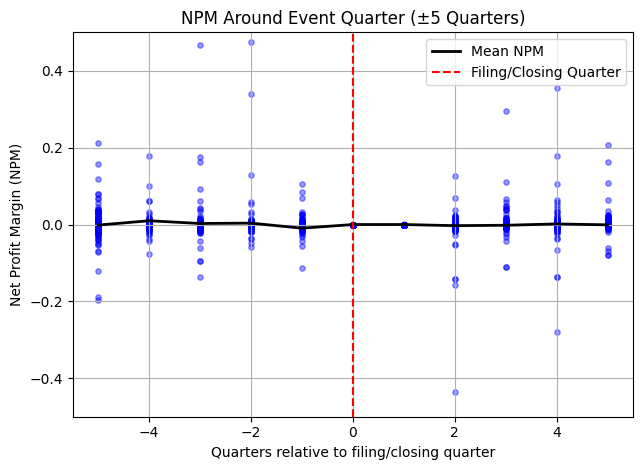

In [314]:
rdd = rnd[rnd['case_length'] == 1]
rdd = rdd[rdd['filing_rd_sale'] != 0]
rdd = rdd[(rdd['filing_rd_sale'] < 10)]
rdd = rdd[(rdd['filed_minus_1_rd_sale'] < 10)]
rdd['delta_minus_1'] = rdd['filed_minus_2_rd_sale'] - rdd['filed_minus_1_rd_sale']
rdd['delta_minus_2'] = rdd['filed_minus_3_rd_sale'] - rdd['filed_minus_2_rd_sale']
rdd['delta_minus_3'] = rdd['filed_minus_4_rd_sale'] - rdd['filed_minus_3_rd_sale']
rdd['delta_minus_4'] = rdd['filed_minus_5_rd_sale'] - rdd['filed_minus_4_rd_sale']
rdd['delta_minus_5'] = rdd['filing_rd_sale'] - rdd['filed_minus_5_rd_sale']
rdd['delta_plus_1'] = rdd['closed_plus_1_rd_sale'] - rdd['filing_rd_sale']
rdd['delta_plus_2'] = rdd['closed_plus_2_rd_sale'] - rdd['closed_plus_1_rd_sale']
rdd['delta_plus_3'] = rdd['closed_plus_3_rd_sale'] - rdd['closed_plus_2_rd_sale']
rdd['delta_plus_4'] = rdd['closed_plus_4_rd_sale'] - rdd['closed_plus_3_rd_sale']
rdd['delta_plus_5'] = rdd['closed_plus_5_rd_sale'] - rdd['closed_plus_4_rd_sale']

# New column order (±5 quarters around filing/closing quarter)
col_order = [
    'delta_minus_5', 'delta_minus_4', 'delta_minus_3',
    'delta_minus_2', 'delta_minus_1', 'delta_rnd_sales',
    'delta_plus_1', 'delta_plus_2', 'delta_plus_3',
    'delta_plus_4', 'delta_plus_5'
]

# Adjusted x-axis (-5 through +5)
x_values = np.arange(-5, 6)

# Plot all individual observations
for idx, row in rdd[col_order].iterrows():
    plt.scatter(x_values, row.values, alpha=0.4, color='blue', s=15)

# Optional: Mean trend line
mean_trend = rdd[col_order].mean()
plt.plot(x_values, mean_trend, color='black', linewidth=2, label='Mean NPM')

# Formatting
plt.xlabel('Quarters relative to filing/closing quarter')
plt.ylabel('Net Profit Margin (NPM)')
plt.title('NPM Around Event Quarter (±5 Quarters)')
plt.axvline(0, color='red', linestyle='--', label='Filing/Closing Quarter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(-0.5,0.5)

plt.show()


In [315]:
rdd['delta_plus_1'].value_counts()

,count
delta_plus_1,
0.000000,229
-0.001108,1
-0.000903,1
0.001068,1


# Fitting Text-Instrument Models (2sls and IV Causal Forrests)